# Step 3: Construct a stage 1 map of all post-QC nuclei
At this point, we've identified low quality clusters from the global map, as well as low quality nuclei within each global cluster. We will construct a stage 1 map at this point that contains all nuclei that pass QC and cluster this into broad cell types. There will be one additional cleaning step before the final map is constructed.

In [2]:
%matplotlib inline

In [3]:
# Libraries
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import re

import scanpy as sc
import harmony
from harmony import harmonize

import warnings

In [3]:
print('scanpy: ' + sc.__version__)
print('pandas: ' + pd.__version__)
print('numpy: ' + np.__version__)
print('harmony: ' + harmony.__version__)

scanpy: 1.7.2
pandas: 1.2.4
numpy: 1.18.1
harmony: 0.1.4


In [4]:
# Turn off some annoying FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Set aggregation path

In [4]:
path_aggregation = '../../data/aggregation'

### Get the full dataset pre-QC
This is count data, unnormalized

In [9]:
# This is the raw data
adata = sc.read(os.path.join(path_aggregation,'humanICM.PreQC.Raw.h5ad'))

Only considering the two last: ['.Raw', '.h5ad'].
Only considering the two last: ['.Raw', '.h5ad'].


In [10]:
# Get the nuclei QC results
qc = pd.read_csv(os.path.join(path_aggregation,'humanICM.PreQC.Harmony/cellQC_results.txt.gz'),
                 sep='\t')

In [11]:
# Subset the h5ad to only the high quality nuclei
adata = adata[adata.obs.index.isin(qc[~qc['outlier']]['Unnamed: 0'])].copy()
adata.shape

(102524, 36601)

### Construct Basic PCA

In [9]:
# No data normalization prior to highly variable gene detection with seurat v3 method
# This should be run on count data (https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor = 'seurat_v3')

In [10]:
# Top 10 highly variable genes
adata.var[adata.var['highly_variable']].sort_values('highly_variable_rank').head(10)

,gene_ids,feature_types,genome,highly_variable,highly_variable_rank,means,variances,variances_norm
TNC,ENSG00000041982,Gene Expression,GRCh38-2020-A_premrna,True,0.0,0.079542,1.500857,13.563186
GPAM,ENSG00000119927,Gene Expression,GRCh38-2020-A_premrna,True,1.0,0.168741,3.281613,13.244156
ITLN1,ENSG00000179914,Gene Expression,GRCh38-2020-A_premrna,True,2.0,0.017450,0.219910,10.748438
PRG4,ENSG00000116690,Gene Expression,GRCh38-2020-A_premrna,True,3.0,0.011753,0.143547,10.729375
DEC1,ENSG00000173077,Gene Expression,GRCh38-2020-A_premrna,True,4.0,0.047716,0.608337,10.487271
AL110292.1,ENSG00000258081,Gene Expression,GRCh38-2020-A_premrna,True,5.0,0.016299,0.231497,10.405540
NRXN1,ENSG00000179915,Gene Expression,GRCh38-2020-A_premrna,True,6.0,0.102464,1.260660,9.352216
XKR4,ENSG00000206579,Gene Expression,GRCh38-2020-A_premrna,True,7.0,0.065604,0.743548,9.188559
LINC01411,ENSG00000249306,Gene Expression,GRCh38-2020-A_premrna,True,8.0,0.018513,0.185898,8.900578
PKN2-AS1,ENSG00000237505,Gene Expression,GRCh38-2020-A_premrna,True,9.0,0.077123,0.783621,8.069845


In [11]:
# Now normalize prior to PCA (and take log)
# We use a normalization factor of 1e4 as is done in Seurat and scanpy default tutorials
# but there are other reasonable choices here
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
# subset to highly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [ ]:
# scale the data
sc.pp.scale(adata, max_value=10)

In [14]:
# Run PCA so we can feed that into harmony
sc.tl.pca(adata, svd_solver='arpack')

In [15]:
# Make a sub-directory to store the post-QC files temporarily
os.system('mkdir ' + os.path.join(path_aggregation,'humanICM.PostQC.Map'))

0

In [16]:
# We will save this PC-space in case we want to re-use it for harmony again later
pd.DataFrame(adata.obsm['X_pca']).to_csv(os.path.join(path_aggregation,'humanICM.PostQC.Map/PC_unadjust.txt.gz'),
                                          sep='\t', index=None, header=None, compression='gzip')

### Run Harmony to align the PC-space by sample

In [17]:
# Make a batch variable -- we want to align across biological individuals
# Therefore we will use the "individual" variable in the dataset
adata.obs['batch'] = adata.obs['individual'].astype('category')

In [18]:
# Run Harmony to align these PCs across individual
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'batch')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


In [19]:
# Save Harmony PC space for later, in case we need to re-run things
pd.DataFrame(Z).to_csv(os.path.join(path_aggregation,'humanICM.PostQC.Map/PC_harmony_adjust.txt.gz'),
                                       sep='\t', index=None, header=None, compression='gzip')

### Construct a global map using the aligned PCs

In [20]:
# This is the raw data
adata = sc.read(os.path.join(path_aggregation,'humanICM.PreQC.Raw.h5ad'))

Only considering the two last: ['.Raw', '.h5ad'].
Only considering the two last: ['.Raw', '.h5ad'].


In [21]:
# Get the nuclei QC results
qc = pd.read_csv(os.path.join(path_aggregation,'humanICM.PreQC.Harmony/cellQC_results.txt.gz'),
                 sep='\t')

In [22]:
# Subset the h5ad to only the high quality nuclei
adata = adata[adata.obs.index.isin(qc[~qc['outlier']]['Unnamed: 0'])].copy()
adata.shape

(102524, 36601)

In [23]:
# Read in the calculated harmony PCs
pcs_harmony = pd.read_csv(os.path.join(path_aggregation,'humanICM.PostQC.Map/PC_harmony_adjust.txt.gz'), 
                          sep = '\t', header = None)
print(pcs_harmony.shape[0])

102524


In [24]:
# Add the harmony-adjusted PCs the adata object
adata.obsm['PC_harmony'] = np.array(pcs_harmony)
del pcs_harmony

In [25]:
sc.settings.verbosity = 3

In [26]:
%%time
# neighbor calculation for harmony-adjusted PCs
# using cosine distance
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep = 'PC_harmony', metric = 'cosine', key_added = 'PC_harmony')

computing neighbors
    finished: added to `.uns['PC_harmony']`
    `.obsp['PC_harmony_distances']`, distances for each pair of neighbors
    `.obsp['PC_harmony_connectivities']`, weighted adjacency matrix (0:01:07)
CPU times: user 1min 6s, sys: 623 ms, total: 1min 7s
Wall time: 1min 7s


In [27]:
%%time
# UMAP with Harmony adjustment
# Note: Default min_dist in scanpy is 0.5 but default in umap-learn is 0.1. 
# I have found 0.2 to work pretty well in the past and use that here.
sc.tl.umap(adata, neighbors_key = 'PC_harmony', min_dist = 0.2)
adata.obsm['UMAP_PC_harmony'] = adata.obsm['X_umap'].copy() # save these UMAP to a specific place

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:42)
CPU times: user 1min 42s, sys: 64.6 ms, total: 1min 42s
Wall time: 1min 42s


In [28]:
%%time
# leiden cluster at 0.5 resolution
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden0.5', neighbors_key = 'PC_harmony')

running Leiden clustering
    finished: found 16 clusters and added
    'leiden0.5', the cluster labels (adata.obs, categorical) (0:00:34)
CPU times: user 34.8 s, sys: 157 ms, total: 35 s
Wall time: 35.1 s


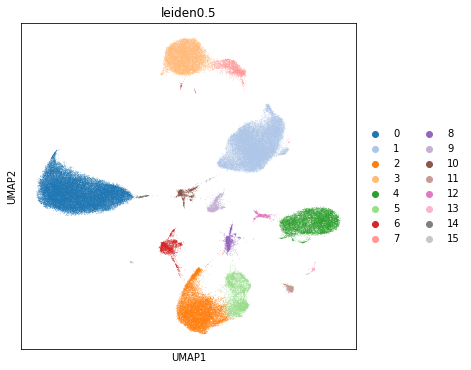

In [29]:
f,ax = plt.subplots(1,1,figsize=(6,6))
adata.obsm['X_umap'] = adata.obsm['UMAP_PC_harmony'].copy()
sc.pl.umap(adata, color = 'leiden0.5', palette = sc.pl.palettes.vega_20,ax=ax)

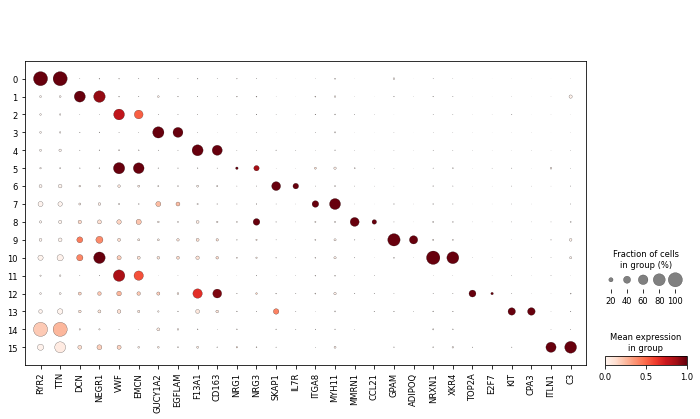

In [6]:
# Look at some of the markers we know from previous work
sc.pl.dotplot(adata, ['RYR2','TTN','DCN','NEGR1','VWF','EMCN','GUCY1A2','EGFLAM',
                      'F13A1','CD163','NRG1','NRG3','SKAP1','IL7R','ITGA8','MYH11',
                      'MMRN1','CCL21','GPAM','ADIPOQ','NRXN1','XKR4',
                      'TOP2A','E2F7','KIT','CPA3', 'ITLN1','C3'],
              groupby = 'leiden0.5', standard_scale='var')

In [33]:
# Representation of cluster by sample
# Note: Cluster 11 is entirely from one borderline sample (1785), we should be cautious here
# Note: Cluster 14 is largely from 1733 -- this appears to be a small myocyte subcluster
# Note: Cluster 15 is largely from 1733 -- this appears to be an epicardial population
pd.crosstab(adata.obs['leiden0.5'], adata.obs['individual'])

individual,1364,1452,1579,1650,1690,1693,1703,1716,1733,1739,1763,1773,1785,1800,1801
leiden0.5,,,,,,,,,,,,,,,
0,2569,2706,254,2650,1479,1231,634,4518,819,3138,1790,2366,2750,2646,1858
1,1158,994,625,2691,1498,801,2085,1208,1381,1184,1817,3718,1307,972,1041
2,1254,884,831,1996,1029,480,477,791,781,869,1320,1368,335,432,665
3,635,719,305,1766,814,228,224,890,518,981,885,1014,739,332,570
4,686,886,80,931,434,287,1023,532,282,402,671,1265,538,612,357
5,275,197,175,386,214,96,186,125,92,537,256,241,1734,89,249
6,203,78,30,300,220,95,89,70,182,155,233,241,155,126,90
7,100,79,117,172,89,55,186,109,73,106,152,407,91,244,69
8,36,27,51,57,81,111,395,41,169,109,74,349,85,91,18


In [34]:
# Save out this map
adata.write(os.path.join(path_aggregation,'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.h5ad'))